In [82]:
from finance_utils.electrical2.spot.probabilistic.forecast.torch.transformer.vanilla_encoder import (
    VanillaTransformerEncoder, vanilla_transformer_tester, vanilla_transformer_trainer, vanilla_transformer_trainer2)

from finance_utils.electrical2.spot.probabilistic.forecast.power.data.meteo2 import PFDInterFace, ecmwf_new_energy_args, cma_new_energy_args
from finance_utils.electrical2.spot.probabilistic.forecast.power.data.tr import TRInterFace

from finance_utils.electrical2.spot.probabilistic.forecast.power.forecast.gridtwicecook import GridTwiceCookedEncoder


from private.db.tencnet.openmeteo.china_openmeteo_forecast3 import ProvinceForecastData, new_or_cat,new_or_stack
from finance_utils.electrical2.spot.probabilistic.forecast.torch.normalization.basic import MinMax,ZScore,RobustScaler
import os
import numpy
import pickle
import tqdm
from easy_datetime.timestamp import TimeStamp


from matplotlib import pyplot as plt
# from data_utils.serial_utils.series_trans_utils import MinMax, ZScore, RobustScaler, KmeansCluster



import torch
from torch import nn

from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor

In [83]:
root = r"E:\code\github\private\private\db\tencnet\openmeteo\data"

with open(f"{root}\\shanxi_1.pfd", "rb") as f:
    pfd: ProvinceForecastData = pickle.loads(f.read())

In [84]:
meteo_source = PFDInterFace.cma

In [85]:
target_day = TimeStamp("2024-11-10")
train_day_1 = TimeStamp(target_day) - ["day", 2]
train_day_2 = TimeStamp(target_day) - ["day", 1]
train_power_1 = TRInterFace.hourly_actual_range("shanxi", train_day_1.get_date_string(), train_day_1.get_date_string())["power"]
train_power_2 = TRInterFace.hourly_actual_range("shanxi", train_day_2.get_date_string(), train_day_2.get_date_string())["power"]
test_power = TRInterFace.hourly_actual_range("shanxi", target_day.get_date_string(), target_day.get_date_string())["power"]

mf = PFDInterFace.directed_forecast(pfd, train_day_2.get_date_string(), [meteo_source.title, "evening"], 9)

100%|██████████| 1140/1140 [00:00<00:00, 4222.37it/s]


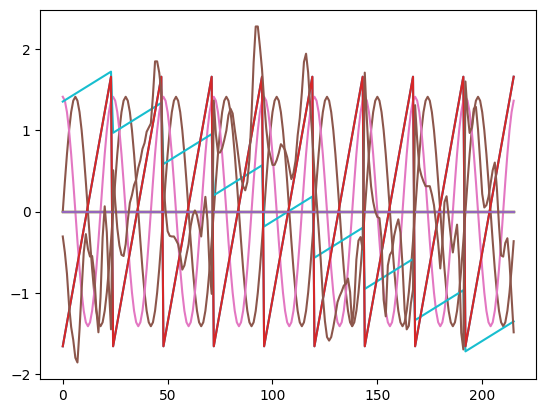

(216, 1140)
(24,)
(24,)


In [90]:
# tm, tl = PFDInterFace.time_periodic_encoding(mfa, 7, False)
# ntm = PFDInterFace.norm_by_meteo_key(tm, ZScore, cma_new_energy_args, tl)
# tm[:,:tl]
# tml = []
# for i in mf:
#     tm,tl = PFDInterFace.time_periodic_encoding(i, 7)
#     tml.append(
#         PFDInterFace.norm_by_meteo_key(tm, ZScore, cma_new_energy_args, tl)
#     )+

tm = numpy.array([])
for i in mf:
    tm = new_or_cat(tm, i)
tm[:,1] = tm[:,0] - tm[:,1]

tc0,tl0 = PFDInterFace.time_periodic_encoding(tm, 0)
tm = new_or_stack(tc0, tm[:,1:])

# tm[:,[0,tl0]]
tl = tl0+6
tl

tm = PFDInterFace.norm_by_meteo_key(tm, ZScore, ZScore, meteo_source.columns, tl)
for i in range(tl+1):
    plt.plot(tm[:,i])
plt.show()

print(tm.shape)
print(train_power_2.shape)
print(test_power.shape)

In [91]:
# input_size = gmf[0].shape[1]
d_model = 128
dim_feedforward = 2048
nhead = 2
output_size = 1
# num_layers = 4
num_layers = 2
# batch_size = fore_days * 4
# batch_size = fore_days // 24//3600 * 4
batch_size = 9 * 4
lr = 1e-3

yp = ZScore.params(train_power_2)
y = ZScore.f(train_power_2)

gtm = PFDInterFace.grid_separate(tm, meteo_source.columns, tl)

trained_model_list = []
for i,tm in enumerate(gtm):
    input_size = tm.shape[1]
    m = VanillaTransformerEncoder(
        input_size=input_size,
        output_size=output_size,
        num_layers=num_layers,
        d_model=d_model,
        nhead=nhead,
        dim_feedforward=dim_feedforward,
        dropout=0.1
    )
    trained_model_list.append(
        vanilla_transformer_trainer2(m, torch.Tensor(tm), torch.Tensor(numpy.tile(y, 9)), batch_size, epochs=50, lr=lr, loser=nn.L1Loss, shuffle=True)
    )
    

100%|██████████| 50/50 [00:01<00:00, 38.82it/s]


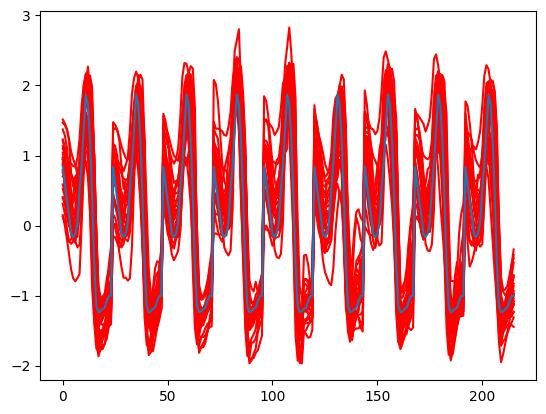

In [92]:
grid_y_hat = []
for i,m in enumerate(trained_model_list):
    p = vanilla_transformer_tester(m, torch.Tensor(tm), batch_size)
    plt.plot(p.reshape(-1).cpu().numpy(), color="red")
    grid_y_hat.append(p.reshape(-1).cpu().numpy())
plt.plot(numpy.tile(y,9))
grid_y_hat = numpy.array(grid_y_hat).T

100%|██████████| 1140/1140 [00:00<00:00, 4969.21it/s]


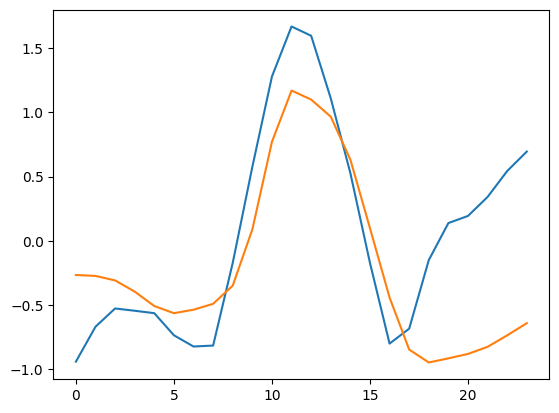

In [94]:
# m1_p_a = numpy.array(m1_p_l).T
# m1_param = []
# for i in range(m1_p_a.shape[1]):
#     m1_param.append(ZScore.params(m1_p_a[:,i]))
#     m1_p_a[:,i] = ZScore.f(m1_p_a[:,i])

mf_test = PFDInterFace.directed_forecast(pfd, target_day.get_date_string(), [meteo_source.title, "evening"], 9)

tm_test = numpy.array([])
for i in mf_test:
    tm_test = new_or_cat(tm_test, i)
tm_test[:,1] = tm_test[:,0] - tm_test[:,1]

tc0_test,tl0_test = PFDInterFace.time_periodic_encoding(tm_test, 0)
tm_test = new_or_stack(tc0_test, tm_test[:,1:])

# tm[:,[0,tl0]]
tl_test = tl0+6
# tl_test

tm_test = PFDInterFace.norm_by_meteo_key(tm_test, MinMax, ZScore, meteo_source.columns, tl_test)
gtm_test = PFDInterFace.grid_separate(tm_test, meteo_source.columns, tl_test)

grid_z_hat = []
for i,m in enumerate(trained_model_list):
    p = vanilla_transformer_tester(m, torch.Tensor(gtm_test[i]), batch_size)
    # plt.plot(p.reshape(-1).cpu().numpy(), color="red")
    grid_z_hat.append(p.reshape(-1).cpu().numpy())
    
#     
plt.plot(
    ZScore.f_with_params(numpy.tile(test_power,9), yp)[-24:]
)
plt.plot(
    numpy.apply_along_axis(numpy.mean, axis=0, arr=numpy.array(grid_z_hat))[-24:]
)


plt.show()